# DonorsChoose

<p>
DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.
</p>
<p>
    Next year, DonorsChoose.org expects to receive close to 500,000 project proposals. As a result, there are three main problems they need to solve:
<ul>
<li>
    How to scale current manual processes and resources to screen 500,000 projects so that they can be posted as quickly and as efficiently as possible</li>
    <li>How to increase the consistency of project vetting across different volunteers to improve the experience for teachers</li>
    <li>How to focus volunteer time on the applications that need the most assistance</li>
    </ul>
</p>    
<p>
The goal of the competition is to predict whether or not a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval.
</p>

## About the DonorsChoose Data Set

The `train.csv` data set provided by DonorsChoose contains the following features:

Feature | Description 
----------|---------------
**`project_id`** | A unique identifier for the proposed project. **Example:** `p036502`   
**`project_title`**    | Title of the project. **Examples:**<br><ul><li><code>Art Will Make You Happy!</code></li><li><code>First Grade Fun</code></li></ul> 
**`project_grade_category`** | Grade level of students for which the project is targeted. One of the following enumerated values: <br/><ul><li><code>Grades PreK-2</code></li><li><code>Grades 3-5</code></li><li><code>Grades 6-8</code></li><li><code>Grades 9-12</code></li></ul>  
 **`project_subject_categories`** | One or more (comma-separated) subject categories for the project from the following enumerated list of values:  <br/><ul><li><code>Applied Learning</code></li><li><code>Care &amp; Hunger</code></li><li><code>Health &amp; Sports</code></li><li><code>History &amp; Civics</code></li><li><code>Literacy &amp; Language</code></li><li><code>Math &amp; Science</code></li><li><code>Music &amp; The Arts</code></li><li><code>Special Needs</code></li><li><code>Warmth</code></li></ul><br/> **Examples:** <br/><ul><li><code>Music &amp; The Arts</code></li><li><code>Literacy &amp; Language, Math &amp; Science</code></li>  
  **`school_state`** | State where school is located ([Two-letter U.S. postal code](https://en.wikipedia.org/wiki/List_of_U.S._state_abbreviations#Postal_codes)). **Example:** `WY`
**`project_subject_subcategories`** | One or more (comma-separated) subject subcategories for the project. **Examples:** <br/><ul><li><code>Literacy</code></li><li><code>Literature &amp; Writing, Social Sciences</code></li></ul> 
**`project_resource_summary`** | An explanation of the resources needed for the project. **Example:** <br/><ul><li><code>My students need hands on literacy materials to manage sensory needs!</code</li></ul> 
**`project_essay_1`**    | First application essay<sup>*</sup>  
**`project_essay_2`**    | Second application essay<sup>*</sup> 
**`project_essay_3`**    | Third application essay<sup>*</sup> 
**`project_essay_4`**    | Fourth application essay<sup>*</sup> 
**`project_submitted_datetime`** | Datetime when project application was submitted. **Example:** `2016-04-28 12:43:56.245`   
**`teacher_id`** | A unique identifier for the teacher of the proposed project. **Example:** `bdf8baa8fedef6bfeec7ae4ff1c15c56`  
**`teacher_prefix`** | Teacher's title. One of the following enumerated values: <br/><ul><li><code>nan</code></li><li><code>Dr.</code></li><li><code>Mr.</code></li><li><code>Mrs.</code></li><li><code>Ms.</code></li><li><code>Teacher.</code></li></ul>  
**`teacher_number_of_previously_posted_projects`** | Number of project applications previously submitted by the same teacher. **Example:** `2` 

<sup>*</sup> See the section <b>Notes on the Essay Data</b> for more details about these features.

Additionally, the `resources.csv` data set provides more data about the resources required for each project. Each line in this file represents a resource required by a project:

Feature | Description 
----------|---------------
**`id`** | A `project_id` value from the `train.csv` file.  **Example:** `p036502`   
**`description`** | Desciption of the resource. **Example:** `Tenor Saxophone Reeds, Box of 25`   
**`quantity`** | Quantity of the resource required. **Example:** `3`   
**`price`** | Price of the resource required. **Example:** `9.95`   

**Note:** Many projects require multiple resources. The `id` value corresponds to a `project_id` in train.csv, so you use it as a key to retrieve all resources needed for a project:

The data set contains the following label (the value you will attempt to predict):

Label | Description
----------|---------------
`project_is_approved` | A binary flag indicating whether DonorsChoose approved the project. A value of `0` indicates the project was not approved, and a value of `1` indicates the project was approved.

### Notes on the Essay Data

<ul>
Prior to May 17, 2016, the prompts for the essays were as follows:
<li>__project_essay_1:__ "Introduce us to your classroom"</li>
<li>__project_essay_2:__ "Tell us more about your students"</li>
<li>__project_essay_3:__ "Describe how your students will use the materials you're requesting"</li>
<li>__project_essay_3:__ "Close by sharing why your project will make a difference"</li>
</ul>


<ul>
Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:<br>
<li>__project_essay_1:__ "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."</li>
<li>__project_essay_2:__ "About your project: How will these materials make a difference in your students' learning and improve their school lives?"</li>
<br>For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be NaN.
</ul>


In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/

from nltk.corpus import stopwords
import pickle

from tqdm import tqdm
import os

## 1. Reading Data

In [2]:
project_data = pd.read_csv('train_data.csv')
resource_data = pd.read_csv('resources.csv')

In [3]:
print("Number of data points in train data", project_data.shape)
print('-'*50)
print("The attributes of data :", project_data.columns.values)

Number of data points in train data (109248, 17)
--------------------------------------------------
The attributes of data : ['Unnamed: 0' 'id' 'teacher_id' 'teacher_prefix' 'school_state'
 'project_submitted_datetime' 'project_grade_category'
 'project_subject_categories' 'project_subject_subcategories'
 'project_title' 'project_essay_1' 'project_essay_2' 'project_essay_3'
 'project_essay_4' 'project_resource_summary'
 'teacher_number_of_previously_posted_projects' 'project_is_approved']


In [4]:
print("Number of data points in train data", resource_data.shape)
print(resource_data.columns.values)
resource_data.head(2)

Number of data points in train data (1541272, 4)
['id' 'description' 'quantity' 'price']


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95


# 2. Preprocessing Categorical Features: project_grade_category

In [5]:
project_data['project_grade_category'].value_counts()

Grades PreK-2    44225
Grades 3-5       37137
Grades 6-8       16923
Grades 9-12      10963
Name: project_grade_category, dtype: int64

we need to remove the spaces, replace the '-' with '_' and convert all the letters to small

In [6]:
# https://stackoverflow.com/questions/36383821/pandas-dataframe-apply-function-to-column-strings-based-on-other-column-value
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace(' ','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.replace('-','_')
project_data['project_grade_category'] = project_data['project_grade_category'].str.lower()
project_data['project_grade_category'].value_counts()

grades_prek_2    44225
grades_3_5       37137
grades_6_8       16923
grades_9_12      10963
Name: project_grade_category, dtype: int64

# 3. Preprocessing Categorical Features: project_subject_categories

In [7]:
project_data['project_subject_categories'].value_counts()

Literacy & Language                           23655
Math & Science                                17072
Literacy & Language, Math & Science           14636
Health & Sports                               10177
Music & The Arts                               5180
Special Needs                                  4226
Literacy & Language, Special Needs             3961
Applied Learning                               3771
Math & Science, Literacy & Language            2289
Applied Learning, Literacy & Language          2191
History & Civics                               1851
Math & Science, Special Needs                  1840
Literacy & Language, Music & The Arts          1757
Math & Science, Music & The Arts               1642
Applied Learning, Special Needs                1467
History & Civics, Literacy & Language          1421
Health & Sports, Special Needs                 1391
Warmth, Care & Hunger                          1309
Math & Science, Applied Learning               1220
Applied Lear

>remove spaces, 'the' <br>
replace '&' with '\_', and ',' with '_'

In [8]:
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' The ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(' ','')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace('&','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.replace(',','_')
project_data['project_subject_categories'] = project_data['project_subject_categories'].str.lower()
project_data['project_subject_categories'].value_counts()

literacy_language                       23655
math_science                            17072
literacy_language_math_science          14636
health_sports                           10177
music_arts                               5180
specialneeds                             4226
literacy_language_specialneeds           3961
appliedlearning                          3771
math_science_literacy_language           2289
appliedlearning_literacy_language        2191
history_civics                           1851
math_science_specialneeds                1840
literacy_language_music_arts             1757
math_science_music_arts                  1642
appliedlearning_specialneeds             1467
history_civics_literacy_language         1421
health_sports_specialneeds               1391
warmth_care_hunger                       1309
math_science_appliedlearning             1220
appliedlearning_math_science             1052
literacy_language_history_civics          809
health_sports_literacy_language   

# 4. Preprocessing Categorical Features: teacher_prefix

In [9]:
project_data['teacher_prefix'].value_counts()

Mrs.       57269
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

In [10]:
# check if we have any nan values are there
print(project_data['teacher_prefix'].isnull().values.any())
print("number of nan values",project_data['teacher_prefix'].isnull().values.sum())

True
number of nan values 3


>numebr of missing values are very less in number, we can replace it with Mrs. as most of the projects are submitted by Mrs.

In [11]:
project_data['teacher_prefix']=project_data['teacher_prefix'].fillna('Mrs.')

In [12]:
project_data['teacher_prefix'].value_counts()

Mrs.       57272
Ms.        38955
Mr.        10648
Teacher     2360
Dr.           13
Name: teacher_prefix, dtype: int64

>Remove '.' <br>
>convert all the chars to small

In [13]:
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.replace('.','')
project_data['teacher_prefix'] = project_data['teacher_prefix'].str.lower()
project_data['teacher_prefix'].value_counts()

mrs        57272
ms         38955
mr         10648
teacher     2360
dr            13
Name: teacher_prefix, dtype: int64

# 5. Preprocessing Categorical Features: project_subject_subcategories

In [14]:
project_data['project_subject_subcategories'].value_counts()

Literacy                                        9486
Literacy, Mathematics                           8325
Literature & Writing, Mathematics               5923
Literacy, Literature & Writing                  5571
Mathematics                                     5379
Literature & Writing                            4501
Special Needs                                   4226
Health & Wellness                               3583
Applied Sciences, Mathematics                   3399
Applied Sciences                                2492
Literacy, Special Needs                         2440
Gym & Fitness, Health & Wellness                2264
ESL, Literacy                                   2234
Visual Arts                                     2217
Music                                           1472
Warmth, Care & Hunger                           1309
Literature & Writing, Special Needs             1306
Gym & Fitness                                   1195
Health & Wellness, Special Needs              

> same process we did in project_subject_categories

In [15]:
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' The ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(' ','')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace('&','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.replace(',','_')
project_data['project_subject_subcategories'] = project_data['project_subject_subcategories'].str.lower()
project_data['project_subject_subcategories'].value_counts()

literacy                                   9486
literacy_mathematics                       8325
literature_writing_mathematics             5923
literacy_literature_writing                5571
mathematics                                5379
literature_writing                         4501
specialneeds                               4226
health_wellness                            3583
appliedsciences_mathematics                3399
appliedsciences                            2492
literacy_specialneeds                      2440
gym_fitness_health_wellness                2264
esl_literacy                               2234
visualarts                                 2217
music                                      1472
warmth_care_hunger                         1309
literature_writing_specialneeds            1306
gym_fitness                                1195
health_wellness_specialneeds               1189
mathematics_specialneeds                   1187
environmentalscience                    

# 6. Preprocessing Categorical Features: school_state

In [16]:
project_data['school_state'].value_counts()

CA    15388
TX     7396
NY     7318
FL     6185
NC     5091
IL     4350
GA     3963
SC     3936
MI     3161
PA     3109
IN     2620
MO     2576
OH     2467
LA     2394
MA     2389
WA     2334
OK     2276
NJ     2237
AZ     2147
VA     2045
WI     1827
AL     1762
UT     1731
TN     1688
CT     1663
MD     1514
NV     1367
MS     1323
KY     1304
OR     1242
MN     1208
CO     1111
AR     1049
ID      693
IA      666
KS      634
NM      557
DC      516
HI      507
ME      505
WV      503
NH      348
AK      345
DE      343
NE      309
SD      300
RI      285
MT      245
ND      143
WY       98
VT       80
Name: school_state, dtype: int64

>convert all of them into small letters

In [17]:
project_data['school_state'] = project_data['school_state'].str.lower()
project_data['school_state'].value_counts()

ca    15388
tx     7396
ny     7318
fl     6185
nc     5091
il     4350
ga     3963
sc     3936
mi     3161
pa     3109
in     2620
mo     2576
oh     2467
la     2394
ma     2389
wa     2334
ok     2276
nj     2237
az     2147
va     2045
wi     1827
al     1762
ut     1731
tn     1688
ct     1663
md     1514
nv     1367
ms     1323
ky     1304
or     1242
mn     1208
co     1111
ar     1049
id      693
ia      666
ks      634
nm      557
dc      516
hi      507
me      505
wv      503
nh      348
ak      345
de      343
ne      309
sd      300
ri      285
mt      245
nd      143
wy       98
vt       80
Name: school_state, dtype: int64

# 7. Preprocessing Categorical Features: project_title

In [3]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

In [20]:
project_data['project_title'].head(5)

0     Educational Support for English Learners at Home
1                Wanted: Projector for Hungry Learners
2    Soccer Equipment for AWESOME Middle School Stu...
3                               Techie Kindergarteners
4                               Interactive Math Tools
Name: project_title, dtype: object

In [21]:
print("printing some random reviews")
print(9, project_data['project_title'].values[9])
print(34, project_data['project_title'].values[34])
print(147, project_data['project_title'].values[147])

printing some random reviews
9 Just For the Love of Reading--\r\nPure Pleasure
34 \"Have A Ball!!!\"
147 Who needs a Chromebook?\r\nWE DO!!


In [22]:
# Combining all the above stundents 
from tqdm import tqdm
def preprocess_text(text_data):
    preprocessed_text = []
    # tqdm is for printing the status bar
    for sentance in tqdm(text_data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\n', ' ')
        sent = sent.replace('\\"', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e.lower() not in stopwords)
        preprocessed_text.append(sent.lower().strip())
    return preprocessed_text

In [23]:
preprocessed_titles = preprocess_text(project_data['project_title'].values)

100%|██████████| 109248/109248 [00:03<00:00, 35678.49it/s]


In [24]:
print("printing some random reviews")
print(9, preprocessed_titles[9])
print(34, preprocessed_titles[34])
print(147, preprocessed_titles[147])

printing some random reviews
9 love reading pure pleasure
34 ball
147 needs chromebook


# 8. Preprocessing Categorical Features: essay

In [25]:
# merge two column text dataframe: 
project_data["essay"] = project_data["project_essay_1"].map(str) +\
                        project_data["project_essay_2"].map(str) + \
                        project_data["project_essay_3"].map(str) + \
                        project_data["project_essay_4"].map(str)

In [26]:
print("printing some random essay")
print(9, project_data['essay'].values[9])
print('-'*50)
print(34, project_data['essay'].values[34])
print('-'*50)
print(147, project_data['essay'].values[147])

printing some random essay
9 Over 95% of my students are on free or reduced lunch.  I have a few who are homeless, but despite that, they come to school with an eagerness to learn.  My students are inquisitive eager learners who  embrace the challenge of not having great books and other resources  every day.  Many of them are not afforded the opportunity to engage with these big colorful pages of a book on a regular basis at home and they don't travel to the public library.  \r\nIt is my duty as a teacher to do all I can to provide each student an opportunity to succeed in every aspect of life. \r\nReading is Fundamental! My students will read these books over and over again while boosting their comprehension skills. These books will be used for read alouds, partner reading and for Independent reading. \r\nThey will engage in reading to build their \"Love for Reading\" by reading for pure enjoyment. They will be introduced to some new authors as well as some old favorites. I want my st

In [27]:
preprocessed_essays = preprocess_text(project_data['essay'].values)

100%|██████████| 109248/109248 [01:12<00:00, 1496.89it/s]


In [28]:
print("printing some random essay")
print(9, preprocessed_essays[9])
print('-'*50)
print(34, preprocessed_essays[34])
print('-'*50)
print(147, preprocessed_essays[147])

printing some random essay
9 95 students free reduced lunch homeless despite come school eagerness learn students inquisitive eager learners embrace challenge not great books resources every day many not afforded opportunity engage big colorful pages book regular basis home not travel public library duty teacher provide student opportunity succeed every aspect life reading fundamental students read books boosting comprehension skills books used read alouds partner reading independent reading engage reading build love reading reading pure enjoyment introduced new authors well old favorites want students ready 21st century know pleasure holding good hard back book hand nothing like good book read students soar reading consideration generous funding contribution help build stamina prepare 3rd grade thank much reading proposal nannan
--------------------------------------------------
34 students mainly come extremely low income families majority come homes parents work full time students s

In [29]:
type(preprocessed_essays)

list

In [30]:
import pickle

In [31]:
with open('preprocessed_essays.pickle', 'wb') as f:
    pickle.dump(preprocessed_essays, f)

# 8. Preprocessing Numerical Values: price

In [30]:
# https://stackoverflow.com/questions/22407798/how-to-reset-a-dataframes-indexes-for-all-groups-in-one-step
price_data = resource_data.groupby('id').agg({'price':'sum', 'quantity':'sum'}).reset_index()
price_data.head(2)

,id,price,quantity
0,p000001,459.56,7
1,p000002,515.89,21


In [31]:
# join two dataframes in python: 
project_data = pd.merge(project_data, price_data, on='id', how='left')

In [32]:
project_data['price'].head()

0    154.60
1    299.00
2    516.85
3    232.90
4     67.98
Name: price, dtype: float64

## 8.1 applying StandardScaler

In [33]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['std_price']=scaler.transform(project_data['price'].values.reshape(-1, 1) )

In [34]:
project_data['std_price'].head()

0   -0.382681
1   -0.000882
2    0.575122
3   -0.175653
4   -0.611708
Name: std_price, dtype: float64

## 8.2 applying MinMaxScaler

In [35]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(project_data['price'].values.reshape(-1, 1))
project_data['nrm_price']=scaler.transform(project_data['price'].values.reshape(-1, 1))

In [36]:
project_data['nrm_price'].head()

0    0.015397
1    0.029839
2    0.051628
3    0.023228
4    0.006733
Name: nrm_price, dtype: float64

## 9 Preparing data for Deep Learning

In [57]:
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [41]:
X = np.array(preprocessed_essays)
y = np.array(project_data['project_is_approved'])

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
del X,y

In [46]:
import numpy
from keras.datasets import imdb
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.embeddings import Embedding
from keras.preprocessing import sequence
from keras.layers import Dropout

Using TensorFlow backend.


In [47]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(X_train)

In [48]:
X_train = tokenizer.texts_to_sequences(X_train)

In [49]:
X_test = tokenizer.texts_to_sequences(X_test)

In [50]:
print(X_train[0])

[1, 45, 1949, 477, 3, 20, 311, 2907, 139, 103, 157, 27, 1749, 33, 1005, 187, 436, 291, 26, 400, 280, 183, 2284, 2956, 69, 1720, 198, 1832, 3, 2045, 54, 287, 33, 629, 544, 252, 1636, 3, 8, 134, 1, 3580, 839, 550, 453, 2333, 5, 58, 20, 169, 55, 2, 1, 14, 11, 208, 93, 13, 20, 10, 289, 2204, 1118, 33, 56, 238, 193, 4, 1, 32, 1399, 28, 11, 72, 185, 33, 56, 343, 65, 22, 462, 28, 61, 303, 659, 244, 11, 33, 343, 252, 1612, 1, 10, 28, 195, 169, 21, 568, 147, 14, 69, 208, 1, 217, 3, 33, 238, 999, 169, 119, 798, 33, 160, 343, 2908, 1, 33, 482, 80, 2, 161, 2333, 1510, 1082, 29, 280, 33, 256, 119, 1206, 287, 33, 29, 80, 280, 493, 343, 482, 80, 2533, 2607, 29, 2224, 130, 363, 471, 179, 689, 419, 1507, 999, 160, 65, 255, 925, 409, 33, 56, 238, 41, 18, 29, 309, 9]


In [51]:
max_review_length = 500
X_train = sequence.pad_sequences(X_train, maxlen=max_review_length)
X_test = sequence.pad_sequences(X_test, maxlen=max_review_length)

print(X_train.shape)
print(X_train[0])

(40000, 500)
[   0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    

## 9.1 LSTM

In [52]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_1 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [53]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Instructions for updating:
Use tf.cast instead.
Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 294s 7ms/step - loss: 0.4168 - acc: 0.8451 - val_loss: 0.4059 - val_acc: 0.8432
Epoch 2/10
40000/40000 [==============================] - 274s 7ms/step - loss: 0.3729 - acc: 0.8500 - val_loss: 0.3998 - val_acc: 0.8432
Epoch 3/10
40000/40000 [==============================] - 267s 7ms/step - loss: 0.3509 - acc: 0.8591 - val_loss: 0.4041 - val_acc: 0.8350
Epoch 4/10
40000/40000 [==============================] - 267s 7ms/step - loss: 0.3342 - acc: 0.8689 - val_loss: 0.4060 - val_acc: 0.8314
Epoch 5/10
40000/40000 [==============================] - 1381s 35ms/step - loss: 0.3172 - acc: 0.8777 - val_loss: 0.4348 - val_acc: 0.8298
Epoch 6/10
40000/40000 [==============================] - 272s 7ms/step - loss: 0.3033 - acc: 0.8849 - val_loss: 0.4296 - val_acc: 0.8219
Epoch 7/10
40000/40000 [==============================] - 265s 7ms/step 

In [54]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.5397310561180114
Test accuracy: 0.8178


In [55]:
def plt_dynamic(x, vy, ty, ax, colors=['b']):
    ax.plot(x, vy, 'b', label="Validation Loss")
    ax.plot(x, ty, 'r', label="Train Loss")
    plt.legend()
    plt.grid()
    fig.canvas.draw()

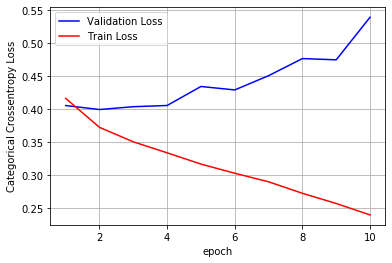

In [58]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [59]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 101       
Total params: 213,301
Trainable params: 213,301
Non-trainable params: 0
_________________________________________________________________
None


In [60]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 281s 7ms/step - loss: 0.4218 - acc: 0.8459 - val_loss: 0.3975 - val_acc: 0.8420
Epoch 2/10
40000/40000 [==============================] - 264s 7ms/step - loss: 0.3749 - acc: 0.8511 - val_loss: 0.3967 - val_acc: 0.8411
Epoch 3/10
40000/40000 [==============================] - 265s 7ms/step - loss: 0.3526 - acc: 0.8596 - val_loss: 0.4005 - val_acc: 0.8398
Epoch 4/10
40000/40000 [==============================] - 288s 7ms/step - loss: 0.3405 - acc: 0.8664 - val_loss: 0.4174 - val_acc: 0.8359
Epoch 5/10
40000/40000 [==============================] - 272s 7ms/step - loss: 0.3243 - acc: 0.8740 - val_loss: 0.4164 - val_acc: 0.8272
Epoch 6/10
40000/40000 [==============================] - 268s 7ms/step - loss: 0.3085 - acc: 0.8826 - val_loss: 0.4549 - val_acc: 0.8233
Epoch 7/10
40000/40000 [==============================] - 267s 7ms/step - loss: 0.2951 - acc: 0.8903 - val_loss: 0.4379 - 

In [61]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.529212663936615
Test accuracy: 0.8162


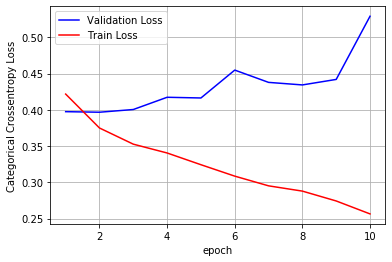

In [62]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [63]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(8, activation='sigmoid'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_3 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 8)                 808       
_________________________________________________________________
dropout_4 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 9         
Total params: 214,017
Trainable params: 214,017
Non-trainable params: 0
_________________________________________________________________
None

In [64]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 268s 7ms/step - loss: 0.4284 - acc: 0.8460 - val_loss: 0.4060 - val_acc: 0.8431
Epoch 2/10
40000/40000 [==============================] - 267s 7ms/step - loss: 0.3980 - acc: 0.8464 - val_loss: 0.4004 - val_acc: 0.8431
Epoch 3/10
40000/40000 [==============================] - 269s 7ms/step - loss: 0.3837 - acc: 0.8464 - val_loss: 0.4034 - val_acc: 0.8431
Epoch 4/10
40000/40000 [==============================] - 267s 7ms/step - loss: 0.3712 - acc: 0.8464 - val_loss: 0.3994 - val_acc: 0.8431
Epoch 5/10
40000/40000 [==============================] - 266s 7ms/step - loss: 0.3633 - acc: 0.8464 - val_loss: 0.4043 - val_acc: 0.8431
Epoch 6/10
40000/40000 [==============================] - 288s 7ms/step - loss: 0.3523 - acc: 0.8488 - val_loss: 0.4048 - val_acc: 0.8431
Epoch 7/10
40000/40000 [==============================] - 333s 8ms/step - loss: 0.3392 - acc: 0.8558 - val_loss: 0.4142 - 

In [65]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.44553551235198974
Test accuracy: 0.7947


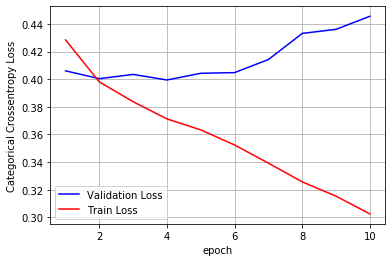

In [66]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [67]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(8, activation='sigmoid'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_4 (LSTM)                (None, 100)               53200     
_________________________________________________________________
dropout_5 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 8)                 808       
_________________________________________________________________
dropout_6 (Dropout)          (None, 8)                 0         
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9         
Total params: 214,017
Trainable params: 214,017
Non-trainable params: 0
_________________________________________________________________
None

In [68]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)


Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 280s 7ms/step - loss: 0.4427 - acc: 0.8456 - val_loss: 0.4102 - val_acc: 0.8431
Epoch 2/10
40000/40000 [==============================] - 278s 7ms/step - loss: 0.4063 - acc: 0.8464 - val_loss: 0.4026 - val_acc: 0.8431
Epoch 3/10
40000/40000 [==============================] - 282s 7ms/step - loss: 0.3846 - acc: 0.8464 - val_loss: 0.4096 - val_acc: 0.8431
Epoch 4/10
40000/40000 [==============================] - 280s 7ms/step - loss: 0.3760 - acc: 0.8464 - val_loss: 0.4085 - val_acc: 0.8431
Epoch 5/10
40000/40000 [==============================] - 281s 7ms/step - loss: 0.3692 - acc: 0.8464 - val_loss: 0.4158 - val_acc: 0.8431
Epoch 6/10
40000/40000 [==============================] - 282s 7ms/step - loss: 0.3633 - acc: 0.8464 - val_loss: 0.4087 - val_acc: 0.8431
Epoch 7/10
40000/40000 [==============================] - 282s 7ms/step - loss: 0.3524 - acc: 0.8464 - val_loss: 0.4336 - 

In [69]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.4556073030233383
Test accuracy: 0.8431


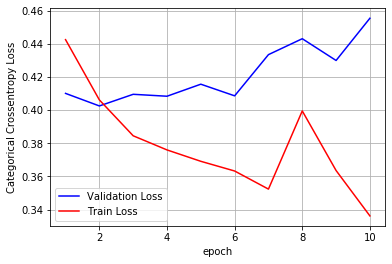

In [70]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [71]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_5 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
lstm_6 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_7 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [72]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 594s 15ms/step - loss: 0.4145 - acc: 0.8448 - val_loss: 0.3985 - val_acc: 0.8431
Epoch 2/10
40000/40000 [==============================] - 588s 15ms/step - loss: 0.3768 - acc: 0.8494 - val_loss: 0.3935 - val_acc: 0.8428
Epoch 3/10
40000/40000 [==============================] - 604s 15ms/step - loss: 0.3578 - acc: 0.8570 - val_loss: 0.3975 - val_acc: 0.8413
Epoch 4/10
40000/40000 [==============================] - 619s 15ms/step - loss: 0.3417 - acc: 0.8661 - val_loss: 0.3999 - val_acc: 0.8382
Epoch 5/10
40000/40000 [==============================] - 637s 16ms/step - loss: 0.3246 - acc: 0.8772 - val_loss: 0.4160 - val_acc: 0.8269
Epoch 6/10
40000/40000 [==============================] - 637s 16ms/step - loss: 0.3095 - acc: 0.8875 - val_loss: 0.4335 - val_acc: 0.8225
Epoch 7/10
40000/40000 [==============================] - 633s 16ms/step - loss: 0.2925 - acc: 0.8979 - val_loss: 0.

In [73]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.5098066158533097
Test accuracy: 0.8233


In [74]:
embedding_vecor_length = 32
model = Sequential()
model.add(Embedding(5000, embedding_vecor_length, input_length=max_review_length))
model.add(LSTM(100, return_sequences=True))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 500, 32)           160000    
_________________________________________________________________
lstm_7 (LSTM)                (None, 500, 100)          53200     
_________________________________________________________________
lstm_8 (LSTM)                (None, 100)               80400     
_________________________________________________________________
dropout_8 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 101       
Total params: 293,701
Trainable params: 293,701
Non-trainable params: 0
_________________________________________________________________
None


In [75]:
epochs = 10
batch_size=64
history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, verbose=1, validation_data=(X_test, y_test)) 
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)

Train on 40000 samples, validate on 10000 samples
Epoch 1/10
40000/40000 [==============================] - 641s 16ms/step - loss: 0.4152 - acc: 0.8465 - val_loss: 0.3946 - val_acc: 0.8432
Epoch 2/10
40000/40000 [==============================] - 642s 16ms/step - loss: 0.3720 - acc: 0.8509 - val_loss: 0.4039 - val_acc: 0.8250
Epoch 3/10
40000/40000 [==============================] - 648s 16ms/step - loss: 0.3525 - acc: 0.8619 - val_loss: 0.3974 - val_acc: 0.8345
Epoch 4/10
40000/40000 [==============================] - 659s 16ms/step - loss: 0.3334 - acc: 0.8728 - val_loss: 0.4222 - val_acc: 0.8324
Epoch 5/10
40000/40000 [==============================] - 659s 16ms/step - loss: 0.3158 - acc: 0.8828 - val_loss: 0.4150 - val_acc: 0.8295
Epoch 6/10
40000/40000 [==============================] - 649s 16ms/step - loss: 0.2920 - acc: 0.8953 - val_loss: 0.4584 - val_acc: 0.8192
Epoch 7/10
40000/40000 [==============================] - 644s 16ms/step - loss: 0.2732 - acc: 0.9072 - val_loss: 0.

In [76]:
print('Test score:', scores[0]) 
print('Test accuracy:', scores[1])

Test score: 0.5495927807092666
Test accuracy: 0.8223


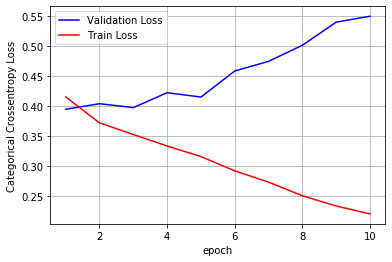

In [77]:
fig,ax = plt.subplots(1,1)
ax.set_xlabel('epoch') ; ax.set_ylabel('Categorical Crossentropy Loss')
x = list(range(1,epochs+1))
vy = history.history['val_loss']
ty = history.history['loss']
plt_dynamic(x, vy, ty, ax)

In [78]:
from prettytable import PrettyTable

x = PrettyTable()
x.field_names = ["Model", "Accuracy"]
x.add_row(["LSTM + DO (0.3)", 0.8178])
x.add_row(["LSTM + DO (0.5)", 0.8162])
x.add_row(["LSTM + DO (0.3) + MLP + DO (0.3)", 0.7947])
x.add_row(["LSTM + DO (0.3) + MLP + DO (0.3)", 0.8431])
x.add_row(["LSTM 2-layers + DO (0.3) ", 0.8233])
x.add_row(["LSTM 2-layers + DO (0.5) ", 0.8223])

print(x)

+----------------------------------+----------+
|              Model               | Accuracy |
+----------------------------------+----------+
|         LSTM + DO (0.3)          |  0.8178  |
|         LSTM + DO (0.5)          |  0.8162  |
| LSTM + DO (0.3) + MLP + DO (0.3) |  0.7947  |
| LSTM + DO (0.3) + MLP + DO (0.3) |  0.8431  |
|    LSTM 2-layers + DO (0.3)      |  0.8233  |
|    LSTM 2-layers + DO (0.5)      |  0.8223  |
+----------------------------------+----------+
